# **Importing Necassary Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **Mapping Classes to Data**

In [2]:
df = pd.read_csv(f"G:\projects\FinalYear\Dataset4\kaggle\working\GaussianFilteredDRClassifiedImages.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["level"].map(diagnosis_binary.get)
df["type"] = df["level"].map(diagnosis_classes.get)

# **Data Visualization**

In [3]:
df.head()

,image,level,binary,type
0,10_left,0,No_DR,No_DR
1,10_right,0,No_DR,No_DR
2,15_left,1,DR,Mild
3,15_right,2,DR,Moderate
4,16_left,4,DR,Proliferate_DR


<Axes: >

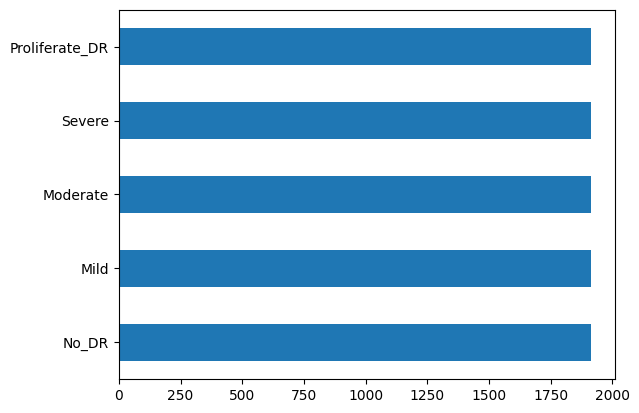

In [4]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

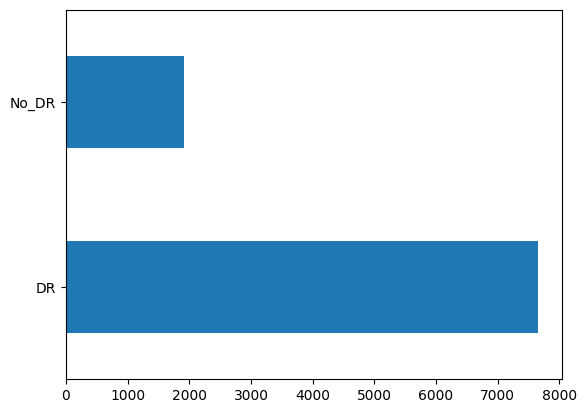

In [5]:
df['binary'].value_counts().plot(kind='barh')

# **Data Preprocessing**

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
%pip install imutils
from imutils import paths
from sklearn.utils import shuffle

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=563072fb431ac3ba6c1ff29bc50287cbb697f03c6aaeb8a52d4d9ccd487d51ce
  Stored in directory: c:\users\sathv\appdata\local\pip\cache\wheels\85\cf\3a\e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


>***Gathering Images and Lables***

In [7]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images(f'G:\projects\FinalYear\Dataset4\kaggle\working\GaussianFilteredDRClassified'))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

>***Normalizing the Data***

In [ ]:
data = data / 255.0

# **Splitting Data to Training , Validatoin and Testing Sets**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

# **Preparing VGG16 Pretrained Model**

In [ ]:
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.applications.densenet import DenseNet201

In [ ]:
DenseNet201 = DenseNet201(include_top=False, input_shape= (224,224,3)) 
DenseNet201.trainable=False

# **Fine-Tuning VGG16**

In [ ]:
model = Sequential()
model.add(DenseNet201)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="{}_drs_weights.best.hdf5".format('densenet_1_1_5_2023')

checkpoint = ModelCheckpoint(weight_path, verbose=1, 
                             save_best_only=True,save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=50) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
history = model.fit(x_train , y_train , epochs=100 , batch_size=64,
                    validation_data=(x_val,y_val), verbose=1 , callbacks = callbacks_list)

In [ ]:
# callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

# history = model.fit(x_train , y_train , epochs=50 , batch_size=64,
#                     validation_data=(x_val,y_val), verbose=1 , callbacks = callbacks)

# **Evaluating the Model Performance**

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [ ]:
plot_curves(history)

In [ ]:
score = model.evaluate(x_test,y_test)

# **Predicting a new Sample**

In [ ]:
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
def predict_new(path):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

In [ ]:
predict_new("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0ceb222f6629.png")
#True --> Mild

In [ ]:
model.save('densenet_1_15_4_2023.h5')